In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import pickle

class TextClassifier:
    def __init__(self, embedding_model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        self.embedding_model_name = embedding_model_name
        self.embedding_model = SentenceTransformer(embedding_model_name)
        self.label_encoder = LabelEncoder()
        self.classifier = LogisticRegression(max_iter=1000)

    def prepare_data(self, df: pd.DataFrame, text_cols: List[str], label_col: str = ""):
        if label_col != "":
            y = self.label_encoder.fit_transform(df[label_col])
        else:
            y = None
        
        # replace empty by empty string
        df[text_cols] = df[text_cols].fillna("")
        
        
        # Encode each text column and concatenate
        embeddings = []
        for col in text_cols:
            col_embedding = self.embedding_model.encode(df[col].tolist())
            embeddings.append(col_embedding)

        X = np.concatenate(embeddings, axis=1)
        return X, y

    def reverse_label_encoder(self, y_pred: np.ndarray) -> np.ndarray:
        return self.label_encoder.inverse_transform(y_pred)
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.classifier.fit(X_train, y_train)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.classifier.predict(X_test)

    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray):
        y_pred = self.predict(X_test)
        print(
            classification_report(
                y_test,
                y_pred,
                labels=np.unique(y_test),
            )
        )
    
    def save(self, filepath: str):
        model_data = {
            'classifier': self.classifier,
            'label_encoder': self.label_encoder,
            'embedding_model_name': self.embedding_model_name
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
    
    @classmethod
    def load(cls, filepath: str):
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        classifier = cls(embedding_model_name=model_data['embedding_model_name'])
        classifier.classifier = model_data['classifier']
        classifier.label_encoder = model_data['label_encoder']
        return classifier

In [49]:
df = pd.read_csv('train.csv')
classifier = TextClassifier()
X, y = classifier.prepare_data(df, text_cols=['designation','description'], label_col='class')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

classifier.train(X_train, y_train)
classifier.save('model.pkl')
classifier.evaluate(X_test, y_test)


              precision    recall  f1-score   support

           0       0.49      0.56      0.52       612
           1       0.63      0.59      0.61       521
           2       0.75      0.73      0.74       357
           3       0.91      0.89      0.90       161
           4       0.69      0.66      0.68       539
           5       0.77      0.87      0.82       786
           6       0.55      0.40      0.46       146
           7       0.58      0.53      0.56       961
           8       0.51      0.38      0.44       424
           9       0.80      0.88      0.84       974
          10       0.83      0.84      0.83       169
          11       0.70      0.64      0.67       507
          12       0.63      0.63      0.63       672
          13       0.73      0.74      0.73      1013
          14       0.86      0.85      0.86       841
          15       0.83      0.88      0.85       137
          16       0.73      0.72      0.73      1029
          17       0.80    

Text(95.72222222222221, 0.5, 'True')

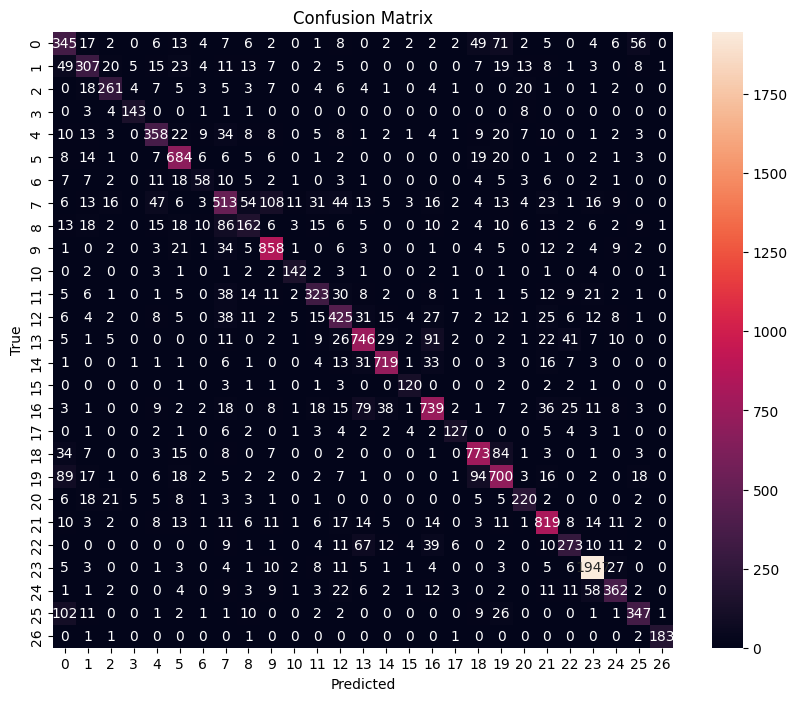

In [50]:
import matplotlib.pyplot as plt
# show confusion matrix with sns
y_pred = classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

In [51]:
# run on test data
test_df = pd.read_csv("X_test.csv")
print("Done loading test data")

# load model
classifier:TextClassifier = TextClassifier.load("model.pkl")
print("Done loading model")

# predict
X, _ = classifier.prepare_data(test_df, ["designation", "description"])
print("Done preparing data")

predictions = classifier.predict(X)

# create a dataframe with the predictions
res_df = pd.DataFrame(predictions, columns=["prdtypecode"])

# save the predictions
res_df.to_csv("predictions.csv", index=False)
print("Done saving predictions")


Done loading test data
Done loading model
Done preparing data
Done saving predictions


In [79]:
df_preds = pd.read_csv('predictions_raw.csv')
df_xtest = pd.read_csv('X_test.csv')

In [80]:
df_preds[""] = df_xtest["Unnamed: 0"]
df_preds = df_preds.rename(columns={"prediction": "prdtypecode"})
df_preds = df_preds.reindex(columns=["", "prdtypecode"])

# label encorder reversing
res = classifier.label_encoder.inverse_transform(df_preds["prdtypecode"])

df_preds["prdtypecode"] = res
df_preds.to_csv("predictions.csv", index=False)
